In [1]:
# ============================================
# 🧊 Titanic 生存予測プロジェクト
# Author: k-ohyeah
# Date: 2025-10-04
# Model: Logistic Regression + Feature Engineering
# ============================================

# 目的：
# Titanicデータセットを用いて、生存者を予測する分類モデルを作成する。
# データ理解 → 前処理 → 特徴量エンジニアリング → モデル構築 → チューニング → 評価 の流れで進める。

#以下一連の流れ・コードを学習
#特徴量の追加によって、AccuracyやROC AUCの変化を確認

# 手順概要：
# 1. データの確認・可視化
# 2. 前処理（欠損補完、カテゴリ処理など）
# 3. 特徴量エンジニアリング（Title作成、FamilySizeなど）
# 4. モデル構築（ロジスティック回帰、決定木、ランダムフォレスト）
# 5. モデル比較とチューニング（GridSearchCV）
# 6. 最終評価と提出データ作成

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
#ライブラリ読み込み
# 以下データ分析の”三種の神器”
import pandas as pd #pandas=表形式ライブラリ
import matplotlib.pyplot as plt #matplotlib.pyplot＝グラフ描画ライブラリ
import seaborn as sns #seaborn＝matplotlibをベースにした、きれいなグラフが簡単に描けるライブラリ

#データ読み込み
train = pd.read_csv("/kaggle/input/titanic/train.csv") #pd.read_csv("ファイルパス"): CSVファイルを読み込んで DataFrame（表形式データ）として保持
train.head() #.head() は 最初の5行だけ表示してデータの中身を確認する関数

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#欠損値チェック

# データ件数（行数）
print("データ件数:", len(train)) #データの 行数（観測数）
print() #改行
#len() で出している データ件数 は タイトル行（カラム名の行）を含みません。
#CSV を読み込むときに、最初の行は「ヘッダー（列名）」として処理されるからです。

# 各列ごとの欠損数
print("各列の欠損数:")
print(train.isnull().sum())
#.isnull() → データが「欠損（NaN = 値がない）」かどうかを True/False で返す
#.sum() → True を 1 としてカウントして合計を出す


#----------------------------------------------------------
#同一セルで複数処理の実行結果を表示する方法
#1.print文を使う

#print(train.head())
#print(train.isnull().sum())

#->これなら両方出ます。

#2Notebookでは display() を使う

#from IPython.display import display

#display(train.head())
#display(train.isnull().sum())

#->Jupyter系の環境ではこちらの方がきれいに出ます。

データ件数: 891

各列の欠損数:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [5]:
#欠損値補完

# Pclass（客室クラス）ごとに Age の中央値で欠損を埋める
#train['Age'] = train.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

#train['Age'] → 「Age」列を指定。
#.fillna() → 欠損値（NaN）を埋めるメソッド。
#train['Age'].mean() → Age列の平均値を計算。

#Age欠損補完の別案
# Name から敬称（Title）を抽出しておく（例: Mr, Mrs, Miss, Master 等）
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# 敬称ごとに Age の中央値で補完（上書き）
train['Age'] = train.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Embarked の欠損を最頻値で補完
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
#.mode() → 最頻値を返す。結果はリストのような形式で返るので [0] をつけて取り出す。

# Fare の欠損を中央値で補完
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
#->欠損なし

#.median() → 中央値を計算。
#Fareは外れ値（極端に大きい運賃）があるため、平均より中央値を使う方が自然なことが多い。

In [6]:
# Cabin → 欠損が多すぎるので「有無フラグ」を作成
train['Cabin_flag'] = train['Cabin'].notnull().astype(int) 

In [7]:
#特徴量作成

# 家族人数 = 同乗の兄弟/配偶者 (SibSp) + 親/子 (Parch) + 自分1人
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

#必要であれば IsAlone = (FamilySize == 1).astype(int) のように孤独フラグを作る手もあります。

In [8]:
#特徴量追加

# 新しい特徴量の作成
train["Age*Class"] = train["Age"] * train["Pclass"]

train["Fare_per_person"] = train["Fare"] / (train["FamilySize"])
#Titanicデータセットの  は チケット単位の合計運賃 を表しています。

train["IsAlone"] = (train["FamilySize"] == 1).astype(int)
#train["FamilySize"] == 1
 #FamilySize が 1 の場合、つまり「兄弟・配偶者・親・子供が誰もいない」＝単独乗船。
 #この条件式は、該当する行に True、それ以外に False を返します。
#.astype(int)
 #True → 1、False → 0 に変換します。
 #結果として、IsAlone 列には以下のような値が入ります：
 #1：一人で乗船していた
 #0：家族や親戚と一緒に乗船していた


In [9]:
#不要列削除

cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Title']  # Cabinはフラグ作成済みなので本体は削除
train = train.drop(columns=cols_to_drop)

#PassengerId や Name、Ticket はそのままだとモデルの説明力が低い／過学習要因になりやすいので、モデリング前に落とす
#（ただし提出時は PassengerId は使うので別途保持しておく）。
#Cabin は生データは大量欠損のため削除、代わりに Cabin_flag を使用。



In [10]:
#カテゴリ変数のエンコーディング

from sklearn.preprocessing import LabelEncoder

# Sexを0,1に変換
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
#LabelEncoder は文字列ラベルを 整数に変換 するツール
#「どっちが0でどっちが1か」は アルファベット順 で決まります。


# EmbarkedをOne-Hot
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True, dtype=int)
#get_dummies はカテゴリ変数を 0/1のダミー変数（One-Hot） に変換する
#drop_first=True にすると 1つの列を削除して多重共線性を避ける
#例えば、Embarked に "C", "Q", "S" がある場合:
#drop_first=True → "C" を基準にして "Q" と "S" の列だけ作る
#"C" の場合は両方 0、"Q" の場合は Q=1, S=0、"S" の場合は Q=0, S=1
#dtype=int:bool → int 変換

In [11]:
#補完後の検査

print("データ件数:", len(train)) #データの 行数（観測数）
print() #改行

print("各列の欠損数(補完後):")
print(train.isnull().sum())

データ件数: 891

各列の欠損数(補完後):
Survived           0
Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               0
Cabin_flag         0
FamilySize         0
Age*Class          0
Fare_per_person    0
IsAlone            0
Embarked_Q         0
Embarked_S         0
dtype: int64


In [12]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_flag,FamilySize,Age*Class,Fare_per_person,IsAlone,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,2,66.0,3.62500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,2,38.0,35.64165,0,0,0
2,1,3,0,26.0,0,0,7.9250,0,1,78.0,7.92500,1,0,1
3,1,1,0,35.0,1,0,53.1000,1,2,35.0,26.55000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,1,105.0,8.05000,1,0,1


In [13]:
#説明変数と目的変数に分ける

X = train.drop("Survived", axis=1)  # 説明変数
y = train["Survived"]               # 目的変数

#train.drop("Survived", axis=1)
#drop は列や行を削除するメソッド。ここでは列 "Survived" を削除して 説明変数だけの DataFrame を作っています。
#axis=1 は「列方向を指定（行なら axis=0）」という意味です。
#結果は X（DataFrame）になります。

#y = train["Survived"]
#train["Survived"] は Survived 列を取り出して シリーズ（Series） にします。これが目的変数（教師ラベル）です。
#以後モデルは X（説明変数）を見て y（0/1）を予測します。


print(X.shape, y.shape)      # データ数・特徴量数の確認
print(X.dtypes.value_counts())  # 何型の列があるか（数値以外が残ってないか確認）

#特に X に object 型（文字列）が残っていると scikit-learn がエラー/警告を出すことがあります。すべて数値型か bool→int にしておいてください。

(891, 13) (891,)
int64      9
float64    4
Name: count, dtype: int64


In [14]:
#学習データと検証データに分割する

from sklearn.model_selection import train_test_split
#sklearn（サイキットラーン）は Python の機械学習ライブラリ
#model_selection モジュールには データを学習用と検証用に分ける便利関数 がいくつか入っています
#train_test_split はその中の関数で、データをランダムに分割してくれる関数です

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#train_test_split(...) の戻り値
#左から順に X_train, X_val, y_train, y_val が返ってきます。
#X_train/y_train を使ってモデルを学習し、X_val/y_val で評価します。

#引数の意味
#test_size=0.3：データの30%を検証用（バリデーション）として確保します。残り70%が学習用。
#random_state=42：乱数の種。再現性を保つために固定します。
#stratify=y：目的変数 y（生存ラベル）の比率を train/val に同じ比率で保つように分割します（クラス不均衡対策）。

print(X_train.shape, X_val.shape)    # 行数・列数を確認
print(y_train.mean(), y_val.mean())  # 生存率が train/val で近いか確認（stratify の効果チェック）

(623, 13) (268, 13)
0.38362760834670945 0.3843283582089552


In [15]:
#前処理がきちんとできているかの確認(一部重複あり)

# 形と型の確認
print("X shape:", X.shape)
print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape)
print("y_train mean (survival rate):", y_train.mean())
print("y_val mean (survival rate):", y_val.mean())

# もし object 型が残っていたら表示
print("\nColumn dtypes:\n", X.dtypes.value_counts())
print("\nObject columns:", [c for c in X.columns if X[c].dtype == 'object'])

#X.shape, X_train.shape, X_val.shape: 説明変数の行数・列数を確認。データ分割がうまくいってるかをチェック。
#y_train.mean(), y_val.mean(): 目的変数の平均（=生存率）を見て、学習・検証データで大きく偏ってないか確認。
#X.dtypes.value_counts(): カラムの型（int, float, object 等）を確認。
#Object columns: モデルが扱えない文字列データが残っていないか確認。

X shape: (891, 13)
X_train shape: (623, 13) X_val shape: (268, 13)
y_train mean (survival rate): 0.38362760834670945
y_val mean (survival rate): 0.3843283582089552

Column dtypes:
 int64      9
float64    4
Name: count, dtype: int64

Object columns: []


In [16]:
#ロジスティック回帰

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

#閾値を変える場合

#from sklearn.metrics import accuracy_score

# 1. 確率を取得（生存クラス=1の確率）
#probas = model.predict_proba(X_val)[:, 1]

# 2. 閾値を設定して0/1に変換
#threshold = 0.4
#y_pred_custom = (probas >= threshold).astype(int)

# 3. Accuracyを計算
#print("Accuracy (threshold=0.4):", accuracy_score(y_val, y_pred_custom))


#LogisticRegression(max_iter=1000)
 #ロジスティック回帰のモデルを作ります。max_iter=1000 は最適化アルゴリズム（勾配法）が収束するまでの最大反復回数で、デフォルトより多めにして収束失敗（ConvergenceWarning）を避ける目的です。
 #もし X のスケールが大きくバラバラ（例：Fareは1000、Ageは30など）なら、スケーリング（StandardScaler）を行うと安定します（ロジスティック回帰は数値のスケールに敏感）。

#model.fit(X_train, y_train)
 #学習（パラメータ推定）を行います。X_train と y_train の形が合っていることが必須です（行数が一致すること）。

#y_pred = model.predict(X_val)
 #学習済みモデルで検証データのラベル（0/1）を予測します。

#accuracy_score(y_val, y_pred)
 #正解率（正しく予測した割合）を出します。単純でわかりやすい指標ですが、クラス不均衡のときは Precision/Recall/F1 も確認したほうが良いです。

Validation Accuracy: 0.7947761194029851


In [17]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))   # precision, recall, f1
probas = model.predict_proba(X_val)[:,1]
print("ROC AUC:", roc_auc_score(y_val, probas))  # 予測確率を使った評価

#predict_proba は各クラスの予測確率を返します（二値分類なら [:,1] が「生存=1」の確率）。
#predict_proba は「クラスごとの予測確率」を返します。
#例えば2クラス分類（0: 死亡, 1: 生存）の場合、
#[:, 0] → クラス0（死亡）の確率
#[:, 1] → クラス1（生存）の確率
#という2列の配列を返します。
#[:,1] とすることで「生存クラス（1）の確率」だけを取り出している。
#ROC AUC は「確率スコア」を使う指標なので、predict（0 or 1 のラベル）ではなく predict_proba の出力を使います。
#つまり probas は「各乗客が生存する確率の予測値（0〜1の実数）」です。

[[139  26]
 [ 29  74]]
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       165
           1       0.74      0.72      0.73       103

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

ROC AUC: 0.8555163283318624


In [18]:
#交差検証 (Cross Validation)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデル
model = LogisticRegression(max_iter=1000, random_state=42)

# 5分割交差検証 (scoring="roc_auc" でAUCを使うことも可能)
scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
scores_roc_auc = cross_val_score(model, X, y, cv=5, scoring="roc_auc") 

print("Cross Validation Accuracies:", scores)
print("Mean Accuracy:", scores.mean())

print("Cross Validation ROC_AUC:", scores_roc_auc) 
print("Mean ROC_AUC:", scores_roc_auc.mean())


Cross Validation Accuracies: [0.77653631 0.80337079 0.78089888 0.78651685 0.8258427 ]
Mean Accuracy: 0.7946331052664617
Cross Validation ROC_AUC: [0.84532279 0.8334893  0.85053476 0.84846257 0.88997474]
Mean ROC_AUC: 0.8535568323133729


In [19]:
#特徴量確認（ロジスティック）

model.fit(X, y) #交差検証時はfitさせる必要あり。（各検証ごとに内部的に学習されているため）

# ロジスティック回帰の係数を確認
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print(coef_df)

#X.columns：説明変数（特徴量）の名前一覧。例えば Age, Fare, Sex_female など。
#model.coef_[0]：ロジスティック回帰モデルが学習した 各特徴量の係数（重み）。
#係数が 正 → その特徴が「1（例：生存）」の予測に貢献。
#係数が 負 → その特徴が「0（例：死亡）」の予測に貢献。
#pd.DataFrame({...})：特徴量とその係数を表形式にまとめます。
#.sort_values(by="Coefficient", ascending=False)：係数が大きい順に並べ替え。影響の強い特徴が上に来ます。


            Feature  Coefficient
6        Cabin_flag     0.563315
4             Parch     0.032287
9   Fare_per_person     0.003449
11       Embarked_Q    -0.000760
5              Fare    -0.000955
8         Age*Class    -0.008825
2               Age    -0.024351
7        FamilySize    -0.244141
12       Embarked_S    -0.262546
3             SibSp    -0.304250
0            Pclass    -0.605703
10          IsAlone    -0.748620
1               Sex    -2.527124


In [20]:
#決定木

#1本の木だけで分類するモデル
#max_depth を指定しないと「過学習」しやすいので、3〜5くらいで試すのが安全

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# モデル作成
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3)  # max_depth=3で木の深さを制限
dt_model.fit(X_train, y_train)

# 予測
y_pred_dt = dt_model.predict(X_val)

# 評価
print("Decision Tree Accuracy:", accuracy_score(y_val, y_pred_dt))
print(confusion_matrix(y_val, y_pred_dt))
print(classification_report(y_val, y_pred_dt))

# ROC AUC
probas_dt = dt_model.predict_proba(X_val)[:, 1]
print("Decision Tree ROC AUC:", roc_auc_score(y_val, probas_dt))

Decision Tree Accuracy: 0.7947761194029851
[[157   8]
 [ 47  56]]
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       165
           1       0.88      0.54      0.67       103

    accuracy                           0.79       268
   macro avg       0.82      0.75      0.76       268
weighted avg       0.81      0.79      0.78       268

Decision Tree ROC AUC: 0.8275963518681966


決定木の特徴量重要度:
            Feature  Importance
1               Sex    0.621328
0            Pclass    0.125309
8         Age*Class    0.112783
9   Fare_per_person    0.082580
5              Fare    0.045248
7        FamilySize    0.012752
2               Age    0.000000
3             SibSp    0.000000
4             Parch    0.000000
6        Cabin_flag    0.000000
10          IsAlone    0.000000
11       Embarked_Q    0.000000
12       Embarked_S    0.000000


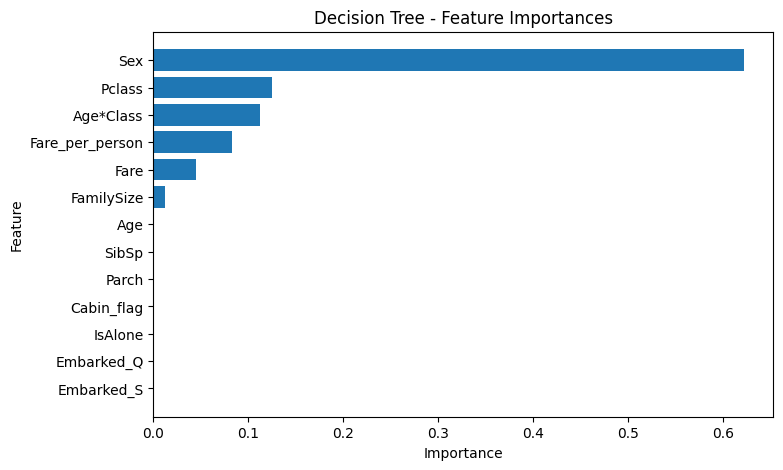

In [21]:
# 決定木の特徴量重要度を取得
dt_importances = dt_model.feature_importances_

# DataFrameにまとめる
dt_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_importances
}).sort_values(by='Importance', ascending=False)

# 表示
print("決定木の特徴量重要度:")
print(dt_feature_importances)

# 可視化
plt.figure(figsize=(8, 5))
plt.barh(dt_feature_importances['Feature'], dt_feature_importances['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Decision Tree - Feature Importances")
plt.gca().invert_yaxis()  # 上位が上に来るよう反転
plt.show()

In [22]:
#ランダムフォレスト

#複数の決定木を「ランダムに作って多数決」するモデル
#過学習を抑えつつ精度が高くなりやすい
#n_estimators = 木の数
#max_depth = 各木の深さ

from sklearn.ensemble import RandomForestClassifier

# モデル作成
rf_model = RandomForestClassifier(
    n_estimators=100,      # 決定木を100本
    max_depth=5,          # 木の深さ制限
    random_state=42
)
rf_model.fit(X_train, y_train)

# 予測
y_pred_rf = rf_model.predict(X_val)

# 評価
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print(confusion_matrix(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))

# ROC AUC
probas_rf = rf_model.predict_proba(X_val)[:, 1]
print("Random Forest ROC AUC:", roc_auc_score(y_val, probas_rf))

Random Forest Accuracy: 0.8059701492537313
[[144  21]
 [ 31  72]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       165
           1       0.77      0.70      0.73       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.81      0.80       268

Random Forest ROC AUC: 0.8670785525154457


In [23]:
# ランダムフォレストの特徴量重要度
importances = rf_model.feature_importances_

#rf_model は事前に学習済みの RandomForestClassifier モデル。
#.feature_importances_ は、各特徴量が予測にどれだけ貢献したかを数値で返します。
#値は 0〜1 の範囲で、合計は 1 になります。
#値が大きいほど、その特徴量がモデルにとって重要。

rf_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(rf_importance_df)

#X.columns：特徴量の名前（例：Age, Fare, Sex_female など）。
#importances：それぞれの特徴量に対応する重要度。
#pd.DataFrame({...})：表形式にまとめる。
#.sort_values(...)：重要度が高い順に並べ替え。


            Feature  Importance
1               Sex    0.331140
8         Age*Class    0.138867
9   Fare_per_person    0.099327
5              Fare    0.099246
6        Cabin_flag    0.097980
2               Age    0.068945
0            Pclass    0.053048
7        FamilySize    0.039986
4             Parch    0.019067
12       Embarked_S    0.016169
3             SibSp    0.015111
10          IsAlone    0.011336
11       Embarked_Q    0.009778


In [24]:
#GridSearchCVでロジスティック回帰

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


# ハイパーパラメータの候補
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # 正則化の強さ
    'penalty': ['l1', 'l2'],        # 正則化の種類
    'solver': ['liblinear']         # solverはliblinearがl1対応
}

# モデル作成
log_reg = LogisticRegression(max_iter=1000)

# GridSearchCVの設定
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='roc_auc',   # ROC-AUCで評価
    cv=5,                # 5分割交差検証
    n_jobs=-1            # 並列実行
)

# 学習
grid_search.fit(X_train, y_train)

# ベストなパラメータとスコア
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# バリデーションデータで予測して確認
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
probas = best_model.predict_proba(X_val)[:,1]

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Validation ROC AUC:", roc_auc_score(y_val, probas))

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Score: 0.8590133381689234
Validation Accuracy: 0.7985074626865671
Validation ROC AUC: 0.8502794939688143


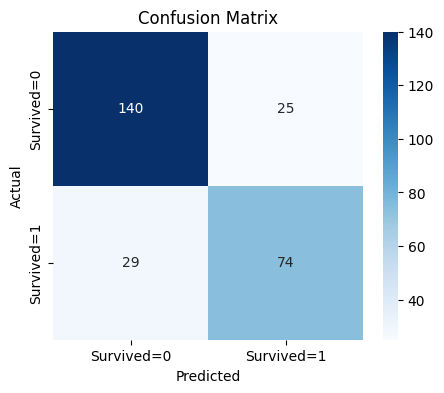

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.83      0.85      0.84       165
    Survived       0.75      0.72      0.73       103

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.79       268
weighted avg       0.80      0.80      0.80       268



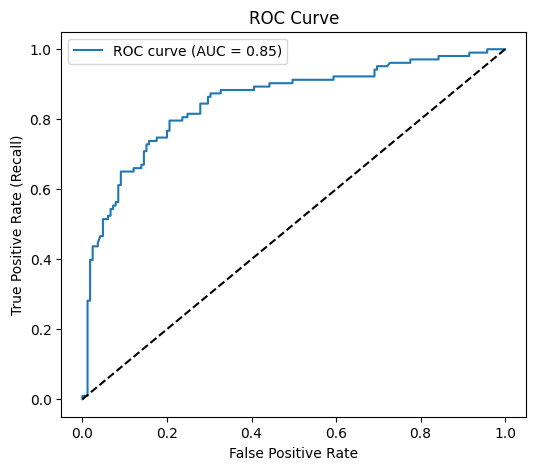

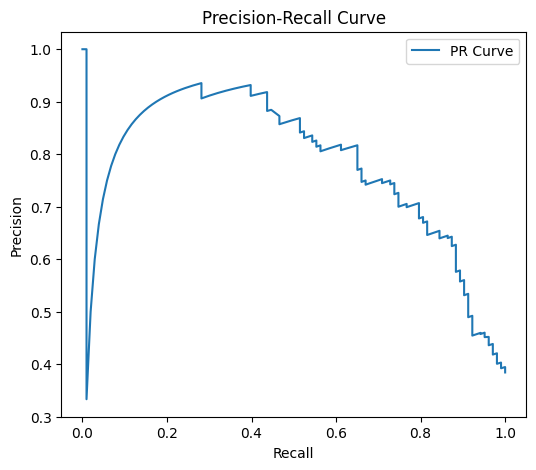

In [25]:
#混同行列（Confusion Matrix）/分類レポート（Precision, Recall, F1-score）/ROC曲線とPR曲線

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 予測ラベル
y_pred = best_model.predict(X_val)

# =========================
# 1. 混同行列
# =========================
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived=0','Survived=1'], yticklabels=['Survived=0','Survived=1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# =========================
# 2. 分類レポート
# =========================
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Not Survived", "Survived"]))

# =========================
# 3. ROC曲線 & PR曲線
# =========================
y_proba = best_model.predict_proba(X_val)[:,1]

# --- ROC曲線
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- Precision-Recall曲線
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [26]:
#誤分類の具体例を調べる

# 検証データで予測
y_pred = best_model.predict(X_val)

# 誤分類（False Negative: 生存者を死亡と予測）
false_negatives = X_val[(y_val == 1) & (y_pred == 0)]
false_negatives_with_labels = pd.concat([false_negatives, y_val[(y_val == 1) & (y_pred == 0)]], axis=1)

false_negatives_with_labels.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_flag,FamilySize,Age*Class,Fare_per_person,IsAlone,Embarked_Q,Embarked_S,Survived
804,3,1,27.0,0,0,6.9750,0,1,81.0,6.9750,1,0,1,1
338,3,1,45.0,0,0,8.0500,0,1,135.0,8.0500,1,0,1,1
431,3,0,35.0,1,0,16.1000,0,2,105.0,8.0500,0,0,1,1
549,2,1,8.0,1,1,36.7500,0,3,16.0,12.2500,0,0,1,1
17,2,1,30.0,0,0,13.0000,0,1,60.0,13.0000,1,0,1,1
489,3,1,9.0,1,1,15.9000,0,3,27.0,5.3000,0,0,1,1
347,3,0,35.0,1,0,16.1000,0,2,105.0,8.0500,0,0,1,1
587,1,1,60.0,1,1,79.2000,1,3,60.0,26.4000,0,0,0,1
444,3,1,30.0,0,0,8.1125,0,1,90.0,8.1125,1,0,1,1
712,1,1,48.0,1,0,52.0000,1,2,48.0,26.0000,0,0,1,1
